# Mushroom Classification Project


## Section 1: Research and Data Exploration

### Section 1.1: Dataset

#### Name and Source of the Data:
The dataset used for this analysis is the Mushroom Dataset from the UCI Machine Learning Repository.
#### Date and Time of Dataset Acquisition:
The dataset was downloaded on [insert date/time here].
#### Reason for Choosing This Dataset:
The Mushroom Dataset was chosen due to its comprehensive set of categorical features, making it ideal for classification problems. Additionally, it provides a real-world application of determining the edibility of mushrooms, which has practical significance in the fields of biology and food safety.
#### Dataset Overview:
The Mushroom Dataset contains records of different mushroom species, detailing various attributes such as cap shape, cap color, gill size, and odor. Each record is classified as either edible or poisonous. This classification problem serves as an excellent example for applying machine learning techniques to predict the edibility of mushrooms based on their characteristics.
#### Objectives: 
The main objective of this analysis is to build a predictive model that can classify mushrooms as either edible or poisonous based on their features. This model will utilise various machine learning algorithms to determine the most accurate method for this classification task. The ultimate goal is to develop a reliable model that can aid in the safe identification of mushrooms in real-world scenarios.

### Section 1.2: Related Work

#### Title of the Paper:
"Using machine learning on cardiorespiratory fitness data for predicting hypertension: The Henry Ford ExercIse Testing (FIT) Project" by Sherif Sakr and Radwa Elshawi.

#### Dataset Overview:
The paper uses the Henry Ford ExercIse Testing (FIT) Project dataset, which contains information on 23,095 patients who underwent clinician-referred exercise treadmill stress testing at Henry Ford Health Systems between 1991 and 2009. This dataset is relevant to my work as it involves the application of machine learning techniques to predict health outcomes, similar to my objective of predicting mushroom edibility.

#### Objectives and Methods:
The paper aims to evaluate and compare the performance of different machine learning techniques for predicting individuals at risk of developing hypertension using cardiorespiratory fitness data. The authors investigated six machine learning techniques: LogitBoost (LB), Bayesian Network classifier (BN), Locally Weighted Naive Bayes (LWB), Artificial Neural Network (ANN), Support Vector Machine (SVM), and Random Tree Forest (RTF). This is relevant to my work as it provides insights into various machine learning methods that can be applied to classification problems.

#### Results:
The results show that the Random Tree Forest (RTF) model achieved the best performance with an AUC of 0.93, outperforming all other machine learning techniques examined in the study. This paper is considered significant due to its comprehensive evaluation of multiple machine learning methods and its demonstration of the effectiveness of RTF in predicting hypertension.

#### Evaluation:
I believe this paper is excellent as it provides a thorough comparison of different machine learning techniques and highlights the importance of model evaluation. The insights gained from this study can be applied to my project to improve the accuracy of mushroom classification models.

### Section 1.3: Data Exploration

#### Importing the necessary libraries


In [ ]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pointbiserialr
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler


#### Loading the Mushroom Dataset
The dataset, obtained from the UCI Machine Learning Repository, includes various features of mushrooms to determine their edibility. The column names have been manually assigned to represent each feature accurately as per the UCI repository documentation.

In [ ]:
# Path to CSV file
file_path = 'Mushrooms.data.csv'

# Column names of dataset 
column_names = [
    'poisonous', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
    'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',
    'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 
    'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 
    'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'
]

# Load the dataset
df = pd.read_csv(file_path, sep=',', names=column_names, header=None)

# Display basic information about the dataset
df.info()

# Display the first few rows of the dataset
df.head()

# Check if there are any missing values in the dataset
missing_values = df.isnull().sum()
print("Missing values per column:")
print(missing_values[missing_values > 0])

# Save the dataframe for the next steps
df.to_csv('explored_mushrooms.csv', index=False)

#### Class Distribution Visualization
To understand the class imbalance in the dataset, the distribution of the target variable (poisonous vs. edible) is visualised.


In [ ]:
# Load the cleaned dataset
df = pd.read_csv('cleaned_mushrooms.csv')

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='poisonous', data=df, hue='poisonous', palette="Set2", legend=False)
plt.title('Class Distribution (Edible vs Poisonous)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()



#### Categorical Feature Distribution Visualization

The distribution of several categorical features is plotted to explore how they vary with the target variable.


In [ ]:
# Plot the distribution of the first few categorical features
plt.figure(figsize=(14, 10))
for i, column in enumerate(df.columns[1:5]):
    plt.subplot(2, 2, i + 1)
    sns.countplot(x=column, data=df, hue='poisonous', palette="Set1", legend=False)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Feature Correlation Visualization

The point-biserial correlation for each feature with the target variable (poisonous vs. edible) is computed and the top 10 correlated features are visualised. This helps identify the features most strongly associated with the target variable.


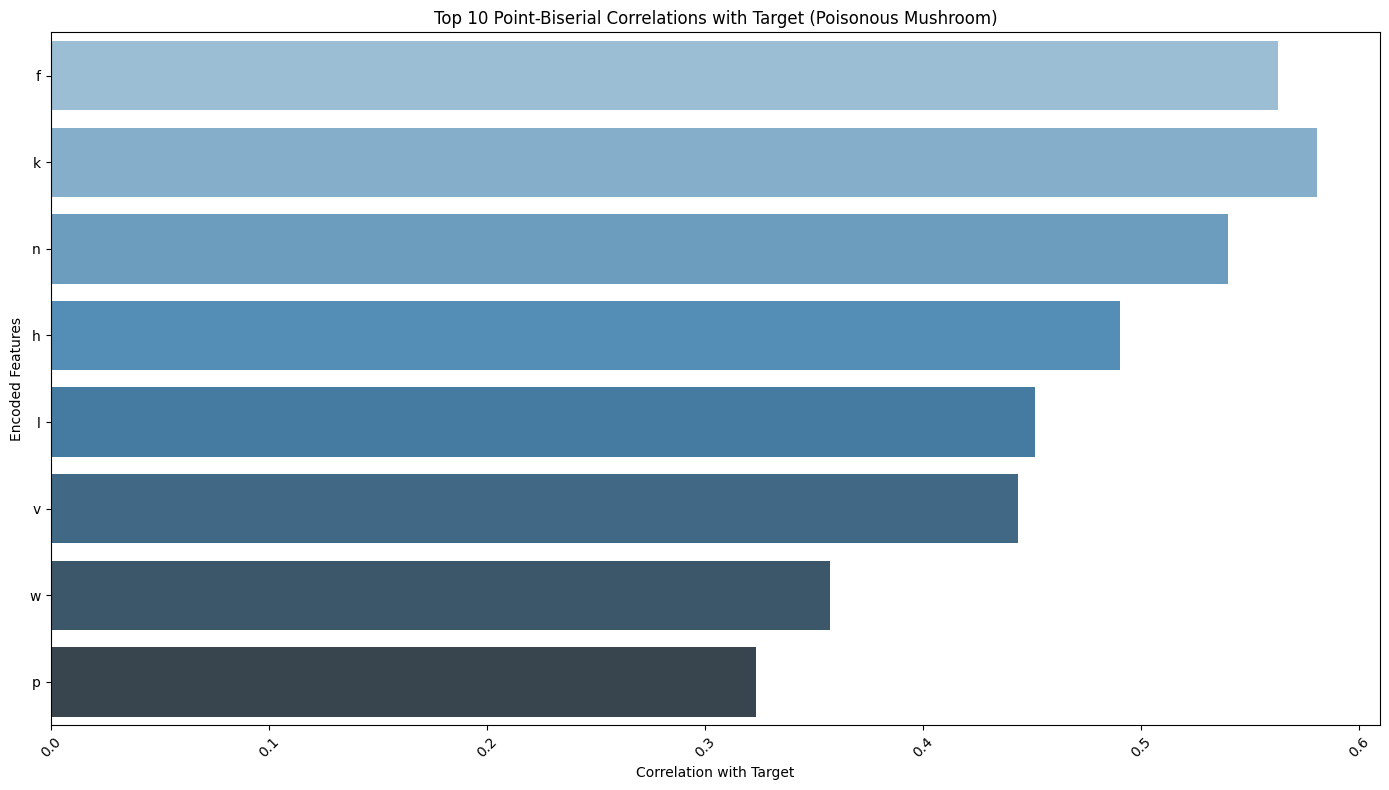

In [38]:
# Load cleaned data
df = pd.read_csv('cleaned_mushrooms.csv')

# Calculate point-biserial correlation for each feature
correlations = []
for column in df.columns[1:]:  
    feature = pd.get_dummies(df[column], drop_first=True) 
    for col in feature.columns:
        corr, _ = pointbiserialr(df['poisonous'], feature[col])
        correlations.append((column, col, corr))

corr_df = pd.DataFrame(correlations, columns=['Feature', 'Encoded Feature', 'Correlation'])
corr_df = corr_df.sort_values(by='Correlation', ascending=False)

# Save top correlated features
top_corr_df = corr_df.head(10)
top_corr_df.to_csv('top_correlated_features.csv', index=False)

# Plot top correlated features
plt.figure(figsize=(14, 8)) 
sns.barplot(x='Correlation', y='Encoded Feature', data=top_corr_df, hue='Encoded Feature', palette='Blues_d', dodge=False, errorbar=None, legend=False)
plt.title('Top 10 Point-Biserial Correlations with Target (Poisonous Mushroom)')
plt.xlabel('Correlation with Target')
plt.ylabel('Encoded Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Section 1.4: Data Pre-processing

#### Data Pre-processing

In this section, the dataset is cleaned and pre-processed by converting categorical values to numerical values and handling any missing data.


In [ ]:
# Load the dataset
df = pd.read_csv('explored_mushrooms.csv')

# Clean and preprocess the data
df['poisonous'] = df['poisonous'].replace({'poisonous': 'p', 'edible': 'e'})
df['poisonous'] = df['poisonous'].map({'p': 1, 'e': 0})

# Handle missing values by filling with mode
df = df.apply(lambda col: col.fillna(col.mode()[0]))

# Save the cleaned dataframe
df.to_csv('cleaned_mushrooms.csv', index=False)


#### Convert Categorical Features and Apply SMOTE

In [ ]:
# Load cleaned data
df = pd.read_csv('cleaned_mushrooms.csv')

# Convert categorical features to one-hot encoded variables
y = df['poisonous']
X = pd.get_dummies(df.drop('poisonous', axis=1), drop_first=True)

# Convert any boolean columns to integers
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

# Verify the encoding
print(X.dtypes)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Continue with feature selection and splitting the dataset
selector = SelectKBest(f_classif, k=10)
X_selected = selector.fit_transform(X_resampled, y_resampled)

X_train, X_test, y_train, y_test = train_test_split(X_selected, y_resampled, test_size=0.2, random_state=42)

# Save train/test data
pd.DataFrame(X_train).to_csv('X_train.csv', index=False)
pd.DataFrame(X_test).to_csv('X_test.csv', index=False)
pd.DataFrame(y_train).to_csv('y_train.csv', index=False)
pd.DataFrame(y_test).to_csv('y_test.csv', index=False)


## Section 2: Modelling/Classification

#### Building and Training the Initial Model
An initial classification model is built using Support Vector Machine (SVM) with default parameters stated in the paper. (https://www.semanticscholar.org/reader/dbfc5a911e50b275d9b8adb5d311286d50b3f9dc)

In [ ]:
# Load train/test data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
y_test = pd.read_csv('y_test.csv').values.ravel()

# Reduce the size of the training data
X_train_reduced = X_train[:3000]
y_train_reduced = y_train[:3000]

# Standardize the data
scaler = StandardScaler()
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test = scaler.transform(X_test)

# Initialize the SVM model with adjusted parameters
initial_svm_model_adjusted = SVC(kernel='sigmoid', C=50, gamma='auto', random_state=42)

# Perform cross-validation
cv_scores_adjusted = cross_val_score(initial_svm_model_adjusted, X_train_reduced, y_train_reduced, cv=5)
print(f"Cross-validation scores (Adjusted Model): {cv_scores_adjusted}")
print(f"Average cross-validation score (Adjusted Model): {np.mean(cv_scores_adjusted)}")

# Train the initial model with adjustments
initial_svm_model_adjusted.fit(X_train_reduced, y_train_reduced)

# Make predictions with the initial model with adjustments
y_pred_initial_adjusted = initial_svm_model_adjusted.predict(X_test)

# Evaluate the initial model with adjustments
print("Initial Model (Adjusted) - Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_initial_adjusted))
print("\nInitial Model (Adjusted) - Classification Report:")
print(classification_report(y_test, y_pred_initial_adjusted))
print("\nInitial Model (Adjusted) - Accuracy Score:")
print(accuracy_score(y_test, y_pred_initial_adjusted))

## Section 3 Solution Improvement

#### Improving the Model
The model is further improved using cross-validation and parameter tuning with the full dataset.

In [39]:
# Load train/test data
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
y_test = pd.read_csv('y_test.csv').values.ravel()

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize the SVM model
svm_model = SVC(kernel='linear', C=0.1, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Average cross-validation score: {np.mean(cv_scores)}")

# Fit the model
svm_model.fit(X_train, y_train)

# Make predictions
y_pred = svm_model.predict(X_test)

# Evaluate the model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nAccuracy Score:")
print(accuracy_score(y_test, y_pred))


Cross-validation scores: [0.97550111 0.97253155 0.98142645 0.97994056 0.97399703]
Average cross-validation score: 0.976679341357328
Confusion Matrix:
[[823  20]
 [ 14 827]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       843
           1       0.98      0.98      0.98       841

    accuracy                           0.98      1684
   macro avg       0.98      0.98      0.98      1684
weighted avg       0.98      0.98      0.98      1684


Accuracy Score:
0.9798099762470309
